In [2]:
from pickle import load

from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.inception_v3 import InceptionV3

from keras_preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from keras.applications.inception_v3 import preprocess_input as inception_preprocess

from keras_preprocessing.sequence import pad_sequences
from numpy import argmax

from matplotlib import image as mpimg, pyplot as plt

from os import system, environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

PATH_TOKENIZER = "tokenizer.pkl"
PATH_VGG16 = "bleu-0512229-vgg16.h5"
PATH_INCEPTION = "bleu-0507810-inception.h5"

TOKENIZER = load(open(PATH_TOKENIZER, 'rb'))
MAX_WORDS = 22

VGG16_EXTRACTOR = VGG16(weights="imagenet")
VGG16_EXTRACTOR = Model(inputs=VGG16_EXTRACTOR.inputs, outputs=VGG16_EXTRACTOR.layers[-2].output)
VGG16_TARGET_SIZE = 224
VGG16_MODEL = load_model(PATH_VGG16)

INCEPTION_EXTRACTOR = InceptionV3(weights="imagenet")
INCEPTION_EXTRACTOR = Model(inputs=INCEPTION_EXTRACTOR.inputs, outputs=INCEPTION_EXTRACTOR.layers[-2].output)
INCEPTION_TARGET_SIZE = 299
INCEPTION_MODEL = load_model(PATH_INCEPTION)

def vgg16_extract(path_image):
    image = load_img(path_image, target_size=(VGG16_TARGET_SIZE, VGG16_TARGET_SIZE))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = vgg16_preprocess(image)

    feature = VGG16_EXTRACTOR.predict(image, verbose=0)
    return feature

def inception_extract(path_image):
    image = load_img(path_image, target_size=(INCEPTION_TARGET_SIZE, INCEPTION_TARGET_SIZE))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = inception_preprocess(image)

    feature = INCEPTION_EXTRACTOR.predict(image, verbose=0)
    return feature

def map_int_to_word(integer):
    for word, idx in TOKENIZER.word_index.items():
        if idx == integer:
            return word

    return None

def generate_caption(model, image_features):
    in_text = 'startseq'

    for i in range(MAX_WORDS):
        seq = TOKENIZER.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=MAX_WORDS)

        y_hat = model.predict([image_features,seq], verbose=0)
        y_hat = argmax(y_hat)

        word = map_int_to_word(y_hat)
        if word is None:
            break

        in_text += ' ' + word

        if word == 'endseq':
            break

    return in_text

def vgg16_generate(path_image):
    image_features = vgg16_extract(path_image)
    caption = generate_caption(VGG16_MODEL, image_features)

    return caption[9:-7]

def inception_generate(path_image):
    image_features = inception_extract(path_image)
    caption = generate_caption(INCEPTION_MODEL, image_features)

    return caption[9:-7]

def print_image(path_image):
    image = mpimg.imread(path_image)
    plt.imshow(image)
    plt.show()

def captions_from_file(path_image):
    print_image(path_image)
    print(vgg16_generate(path_image))
    print(inception_generate(path_image))

def captions_from_url(url):
    system("curl -s {} -o {}".format(url, "temp.jpg"))
    captions_from_file("temp.jpg")

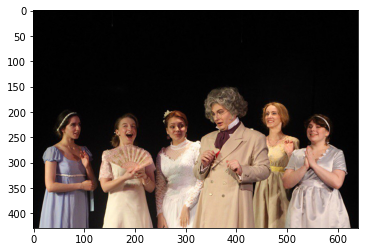

группа людей в черном платье и разговаривают
группа людей сидит на сцене и разговаривают


In [6]:
captions_from_file('D:/downloads/00.jpg')

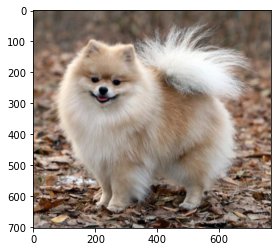

белая собака бежит по траве
собака бежит по траве


In [2]:
captions_from_url('https://i.imgur.com/QzxTOG1.jpg')